# Spherical Gaussian experiment (2D)

## Setup

In [1]:
import sys
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import torch
from torch.utils.data import TensorDataset
import logging


sys.path.append("../../")
from manifold_flow import transforms, utils, distributions, training
from manifold_flow.flows import Flow, ManifoldFlow
from manifold_flow import nn as nn_
from experiments.simulators.spherical_simulator import SphericalGaussianSimulator
from experiments.utils import vector_transforms

%matplotlib inline

logging.basicConfig(
    format="%(asctime)-5.5s %(name)-30.30s %(levelname)-7.7s %(message)s",
    datefmt="%H:%M",
    level=logging.DEBUG,
)
logger = logging.getLogger(__name__)
# Output of all other modules (e.g. matplotlib)
for key in logging.Logger.manager.loggerDict:
    if "experiments" not in key and "manifold_flow" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)


### Settings

In [2]:
epochs = 20
n_train = 10000
epsilon = 0.01

### Data

In [3]:
simulator = SphericalGaussianSimulator(latent_dim=1, data_dim=2, epsilon=epsilon)
x = simulator.sample(n_train)
x_tensor = torch.from_numpy(x)
train_dataset = TensorDataset(x_tensor, x_tensor)

11:02 experiments.simulators.spheric DEBUG   Evaluating true log density for x = [-1.4 -1.4]
11:02 experiments.simulators.spheric DEBUG   Latent variables: z_phi = [3.92699082], z_eps = [0.97989899]
../../experiments/simulators/spherical_simulator.py:108: RuntimeWarning: divide by zero encountered in log
  logp_eps = np.log(norm(loc=0.0, scale=self._epsilon).pdf(z_eps))


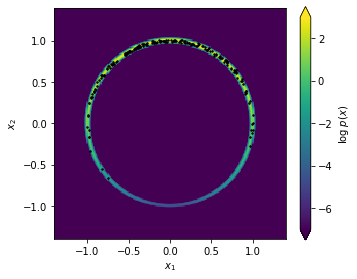

In [4]:
res = 200
x_range = np.linspace(-1.4,1.4,res)
y_range = np.linspace(-1.4,1.4,res)
xx, yy = np.meshgrid(x_range, y_range)
x_grid = np.concatenate((xx.reshape((-1,1)), yy.reshape((-1,1))), axis=1)
logp_grid = simulator.log_density(x_grid, precise=True).reshape((res, res))
logp_grid[~np.isfinite(logp_grid)] = -1000000.

zmin, zmax = np.max(logp_grid) - 10, np.max(logp_grid)
fig = plt.figure(figsize=(5,4))
ax = plt.gca()

pcm = plt.imshow(
    np.clip(logp_grid, zmin, zmax),
    extent=(-1.4,1.4,-1.4,1.4),
    origin="lower",
    cmap="viridis", norm=matplotlib.colors.Normalize(zmin, zmax),
    interpolation='nearest'
)
cb = plt.colorbar(pcm, extend="both")
plt.scatter(x[::50,0], x[::50,1], s=2., c="black", alpha=1.)

plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
cb.set_label("$\log \; p(x)$")
plt.tight_layout()

plt.savefig("spherical_gaussian_2d_data.pdf", dpi=500)

In [5]:
pixel_size = (x_range[1] - x_range[0]) * (y_range[1] - y_range[0])

np.sum(np.exp(logp_grid) * pixel_size)

1.0000930850098504

## Set up models

### Manifold flow

In [ ]:
outer_transform = vector_transforms.create_transform(
    2, 3,
    linear_transform_type="permutation",
    base_transform_type="affine-coupling",
    context_features=None,
    hidden_features=20,
    num_transform_blocks=1,
    resnet_transform=False,
)
inner_transform=transforms.ConditionalAffineScalarTransform(features=1)

mf = ManifoldFlow(
    data_dim=2,
    latent_dim=1,
    inner_transform=inner_transform,
    outer_transform=outer_transform
)

trainer = training.trainer.ManifoldFlowTrainer(mf)
trainer.train(
    train_dataset,
    [training.losses.mse],
    loss_weights=[1.],
    epochs=epochs // 2,
    forward_kwargs={"mode":"projection"}
)
trainer.train(
    train_dataset,
    [training.losses.mse, training.losses.nll],
    loss_weights=[0., 1.],
    epochs=epochs // 2,
    parameters=mf.inner_transform.parameters(),
    forward_kwargs={"mode":"mf"}
)

11:02 manifold_flow.transforms.proje DEBUG   Set up projection from vector with dimension 2 to vector with dimension 1
11:02 manifold_flow.flows.base       DEBUG   Created standard flow with 0.0 M parameters (0.0 M trainable) with an estimated size of 0.0 <B
11:02 manifold_flow.training.trainer INFO    Training on CPU with single precision
11:02 manifold_flow.training.trainer DEBUG   Initialising training data
11:02 manifold_flow.training.trainer DEBUG   Setting up optimizer
11:02 manifold_flow.training.trainer DEBUG   Setting up LR scheduler
11:02 manifold_flow.training.trainer DEBUG   Using early stopping with infinite patience
11:02 manifold_flow.training.trainer DEBUG   Will print training progress every 1 epochs
11:02 manifold_flow.training.trainer DEBUG   Beginning main training loop
11:02 manifold_flow.training.trainer DEBUG   Training epoch 1 / 10
11:02 manifold_flow.training.trainer DEBUG     Learning rate: 0.001
11:02 manifold_flow.training.trainer INFO    Epoch   1: train lo

### PIE

In [ ]:
outer_transform = vector_transforms.create_transform(
    2, 5,
    linear_transform_type="permutation",
    base_transform_type="affine-coupling",
    context_features=None
)
inner_transform=transforms.ConditionalAffineScalarTransform(features=1)

pie = ManifoldFlow(
    data_dim=2,
    latent_dim=1,
    outer_transform=outer_transform,
    inner_transform=inner_transform,
)

trainer = training.trainer.ManifoldFlowTrainer(pie)
trainer.train(
    train_dataset,
    [training.losses.nll],
    loss_weights=[1.],
    epochs=epochs,
    forward_kwargs={"mode":"pie"}
)

## Slice of PIE

In [ ]:
outer_transform = vector_transforms.create_transform(
    2, 5,
    linear_transform_type="permutation",
    base_transform_type="affine-coupling",
    context_features=None
)
inner_transform=transforms.ConditionalAffineScalarTransform(features=1)

slice_of_pie = ManifoldFlow(
    data_dim=2,
    latent_dim=1,
    outer_transform=outer_transform,
    inner_transform=inner_transform,
)

trainer = training.trainer.ManifoldFlowTrainer(slice_of_pie)
trainer.train(
    train_dataset,
    [training.losses.mse],
    loss_weights=[100.],
    epochs=epochs // 2,
    forward_kwargs={"mode": "projection"}
)
trainer.train(
    train_dataset,
    [training.losses.mse, training.losses.nll],
    loss_weights=[0., 1.],
    epochs=epochs // 2,
    parameters=mf.inner_transform.parameters(),
    forward_kwargs={"mode": "slice"}
)

### Standard flow

In [ ]:
transform = vector_transforms.create_transform(
    2, 5,
    linear_transform_type="permutation",
    base_transform_type="affine-coupling",
    context_features=None
)
sf = Flow(
    data_dim=2,
    transform=transform
)

trainer = training.trainer.ManifoldFlowTrainer(sf)
trainer.train(
    train_dataset,
    [training.losses.nll],
    loss_weights=[1.],
    epochs=epochs,
)

## Evaluate the generative performance

### Sample

In [ ]:
x_gen_sf = sf.sample(n=1000).detach().numpy()
x_gen_mf = mf.sample(n=1000).detach().numpy()
x_gen_pie = pie.sample(n=1000).detach().numpy()
x_gen_pie_full = pie.sample(n=1000, sample_orthogonal=True).detach().numpy()

### Distance from manifold, true likelihood of generated samples

In [ ]:
logp_min = -1000

logp_gen_sf = simulator.log_density(x_gen_sf)
logp_gen_mf = simulator.log_density(x_gen_mf)
logp_gen_pie = simulator.log_density(x_gen_pie)
logp_gen_pie_full = simulator.log_density(x_gen_pie_full)

logp_gen_sf[(~np.isfinite(logp_gen_sf)) + (logp_gen_sf<logp_min)] = logp_min
logp_gen_mf[(~np.isfinite(logp_gen_mf)) + (logp_gen_mf<logp_min)] = logp_min
logp_gen_pie[(~np.isfinite(logp_gen_pie)) + (logp_gen_pie<logp_min)] = logp_min
logp_gen_pie_full[(~np.isfinite(logp_gen_pie_full)) + (logp_gen_pie_full<logp_min)] = logp_min

mean_logp_gen_sf = np.mean(logp_gen_sf)
mean_logp_gen_mf = np.mean(logp_gen_mf)
mean_logp_gen_pie = np.mean(logp_gen_pie)
mean_logp_gen_pie_full = np.mean(logp_gen_pie_full)

distance_from_manifold_gen_sf = np.mean(np.abs(np.sum(x_gen_sf**2, axis=1)**0.5 - 1))
distance_from_manifold_gen_mf = np.mean(np.abs(np.sum(x_gen_mf**2, axis=1)**0.5 - 1))
distance_from_manifold_gen_pie = np.mean(np.abs(np.sum(x_gen_pie**2, axis=1)**0.5 - 1))
distance_from_manifold_gen_pie_full = np.mean(np.abs(np.sum(x_gen_pie_full**2, axis=1)**0.5 - 1))

print("Mean true log likelihood of samples generated from flows (higher is better):")
print("  Standard flow:      {:>6.1f}".format(mean_logp_gen_sf))
print("  PIE:                {:>6.1f}".format(mean_logp_gen_pie))
print("  PIE (sampling all): {:>6.1f}".format(mean_logp_gen_pie_full))
print("  Manifold flow:      {:>6.1f}".format(mean_logp_gen_mf))

print("Mean Euclidean distance between samples generated from flows and true manifold (lower is better):")
print("  Standard flow:      {:>6.2f}".format(distance_from_manifold_gen_sf))
print("  PIE:                {:>6.2f}".format(distance_from_manifold_gen_pie))
print("  PIE (sampling all): {:>6.2f}".format(distance_from_manifold_gen_pie_full))
print("  Manifold flow:      {:>6.2f}".format(distance_from_manifold_gen_mf))


### Visualize generated samples

In [ ]:
skip = 10
res = 250
x_range = np.linspace(-1.5,1.5,res)
y_range = np.linspace(-1.5,1.5,res)
xx, yy = np.meshgrid(x_range, y_range)
x_grid = np.concatenate((xx.reshape((-1,1)), yy.reshape((-1,1))), axis=1)
logp_grid = simulator.log_density(x_grid).reshape((res, res))
logp_grid[~np.isfinite(logp_grid)] = -1000000.
zmin, zmax = np.max(logp_grid) - 10., np.max(logp_grid)

fig = plt.figure(figsize=(6,5))
ax = plt.gca()

pcm = plt.imshow(
    np.clip(logp_grid, zmin, zmax),
    extent=(-1.5,1.5,-1.5,1.5),
    origin="lower",
    cmap="Greys",
    norm=matplotlib.colors.Normalize(zmin, zmax),
    interpolation='nearest'
)
cb = plt.colorbar(pcm, extend="both")

plt.scatter(x_gen_sf[::skip,0], x_gen_sf[::skip,1], s=10., c="C0", label="Standard flow")
plt.scatter(x_gen_pie[::skip,0], x_gen_pie[::skip,1], s=10., c="C1", label="PIE")
plt.scatter(x_gen_pie_full[::skip,0], x_gen_pie_full[::skip,1], s=10., c="C2", label="PIE (sampling all)")
plt.scatter(x_gen_mf[::skip,0], x_gen_mf[::skip,1], s=10., c="C3", label="Manifold flow")

plt.legend()

plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
cb.set_label("True log density")

plt.tight_layout()
plt.savefig("spherical_gaussian_2d_generation.pdf")


## Visualize learned likelihoods

### Log likelihood

In [ ]:
res = 100
x_range = np.linspace(-1.5,1.5,res)
y_range = np.linspace(-1.5,1.5,res)
xx, yy = np.meshgrid(x_range, y_range)
x_grid = np.concatenate((xx.reshape((-1,1)), yy.reshape((-1,1))), axis=1)
x_grid_tensor = torch.FloatTensor(x_grid)

learned_logp_grid_mf = mf.log_prob(x_grid_tensor, mode="mf").detach().numpy().reshape((res, res))
learned_logp_grid_mf_slice = mf.log_prob(x_grid_tensor, mode="pie").detach().numpy().reshape((res, res))
learned_logp_grid_sf = sf.log_prob(x_grid_tensor).detach().numpy().reshape((res, res))
learned_logp_grid_pie = pie.log_prob(x_grid_tensor, mode="pie").detach().numpy().reshape((res, res))
learned_logp_grid_slice_of_pie = slice_of_pie.log_prob(x_grid_tensor, mode="slice").detach().numpy().reshape((res, res))

logp_grid_truth = simulator.log_density(x_grid).reshape((res, res))
logp_grid_truth[~np.isfinite(logp_grid_truth)] = -1000000.


In [ ]:
skip = 500

fig = plt.figure(figsize=(12,15))

for i, (label, logp) in enumerate(zip(
    ["True log density", "Standard flow log density", "PIE log density", "Slice of PIE log density", "Manifold flow log density", "Manifold flow, log slice density"],
    [logp_grid_truth, learned_logp_grid_sf, learned_logp_grid_pie, learned_logp_grid_slice_of_pie, learned_logp_grid_mf, learned_logp_grid_mf_slice]
     )):
    ax = plt.subplot(3,2,i+1)

    zmin, zmax = np.max(logp_grid_truth) - 7., np.max(logp_grid_truth) + 3.

    pcm = plt.imshow(
        np.clip(logp, zmin, zmax),
        extent=(-1.5, 1.5, -1.5, 1.5),
        origin="lower",
        cmap="viridis",
        norm=matplotlib.colors.Normalize(zmin, zmax),
        interpolation='nearest'
    )
    cb = plt.colorbar(pcm, extend="both")
    
    # plt.scatter(x[::skip,0], x[::skip,1], s=5., c="black")

    plt.xlim(-1.5,1.5)
    plt.ylim(-1.5,1.5)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    cb.set_label(label)
    
plt.tight_layout()
plt.savefig("spherical_gaussian_2d_log_prob.pdf", dpi=600)


## More visualizations

### Reconstruction

In [ ]:
x_in = SphericalGaussianSimulator(1,2,epsilon=epsilon).sample(100)
x_in = torch.FloatTensor(x_in)
x_out = mf(x_in)[0]
x_in, x_out = x_in.detach().numpy(), x_out.detach().numpy()
dx = x_out - x_in

In [ ]:
fig = plt.figure(figsize=(5,5))
ax = plt.gca()
plt.scatter(x_in[:,0], x_in[:,1], s=15., c="C1")
plt.scatter(x_out[:,0], x_out[:,1], s=15., c="C0")
plt.quiver(
    x_in[:,0], x_in[:,1], dx[:,0], dx[:,1],
    angles='xy', scale_units='xy', scale=1., width=2.e-3, alpha=1.
)

plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.tight_layout()

plt.savefig("spherical_gaussian_2d_reconstruction.pdf")


### Latent variables

In [ ]:
res = 51
x_range = np.linspace(-1.5,1.5,res)
y_range = np.linspace(-1.5,1.5,res)
xx, yy = np.meshgrid(x_range, y_range)
x_grid = np.concatenate((xx.reshape((-1,1)), yy.reshape((-1,1))), axis=1)
x_grid_tensor = torch.FloatTensor(x_grid)

_, _, u = mf(x_grid_tensor)
u = u.detach().numpy()


In [ ]:
zmin, zmax = np.mean(u) - np.std(u), np.mean(u) + np.std(u)
fig = plt.figure(figsize=(5,4))
ax = plt.gca()

pcm = plt.pcolormesh(
    x_range, y_range,
    np.clip(np.clip(u, zmin, zmax).reshape(res, res), zmin, zmax),
    cmap="viridis", norm=matplotlib.colors.Normalize(zmin, zmax)
)
cb = plt.colorbar(pcm, extend="both")
plt.scatter(x_gen_mf[:,0], x_gen_mf[:,1], s=5., c="black")

plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
cb.set_label("$\log \; \hat{p}(x)$")
plt.tight_layout()

plt.savefig("spherical_gaussian_2d_latent.pdf")

## Understanding the MF result

In [ ]:
res = 25
x_range = np.linspace(-1.5,1.5,res)
y_range = np.linspace(-1.5,1.5,res)
xx, yy = np.meshgrid(x_range, y_range)
x = np.concatenate((xx.reshape((-1,1)), yy.reshape((-1,1))), axis=1)
x = torch.FloatTensor(x_grid)


In [ ]:
u, h_manifold, h_orthogonal, log_det_inner, _, jacobian_outer = mf._encode(x, "mf")
_, _, _, _, log_det_outer_full, _ = mf._encode(x, "pie")
x = mf.decode(u)


In [ ]:
jacobian_outer[345]

In [ ]:
# The Jacobian calculated so far is du / dx, need to invert this to get to dx / du
jacobian_outer = torch.inverse(jacobian_outer)
# Next, have to restrict the u space to the manifold direction
jacobian_outer = jacobian_outer[:, :, : self.latent_dim]
# And finally calculate log det (J^T J)
jtj = torch.bmm(torch.transpose(jacobian_outer, -2, -1), jacobian_outer)
log_det_outer = -0.5 * torch.slogdet(jtj)[1]

log_prob = self.manifold_latent_distribution._log_prob(u, context=None)
log_prob = log_prob + log_det_outer + log_det_inner

In [ ]:
fig = plt.figure(figsize=(12,6))

for panel, (label, quantity) in enumerate(zip(
    ["Perp latent", "Manifold latent after outer flow", "Manifold latent after inner flow",
     "log det outer (manifold)", "log det outer (full)", "Base log prob"],
    [h_orthogonal, h_manifold, u, log_det_outer, log_det_outer_full, log_prob_latent]
)):
    ax = plt.subplot(2,3,panel+1)
    
    quantity_ = quantity.detach().numpy()
    quantity_ = quantity_.flatten() + np.zeros((res**2))
    zmin, zmax = np.mean(quantity_) - 1.5 * np.std(quantity_), np.mean(quantity_) + 1.5 * np.std(quantity_)

    pcm = plt.pcolormesh(
        x_range, y_range,
        np.clip(np.clip(quantity_, zmin, zmax).reshape(res, res), zmin, zmax),
        cmap="viridis", norm=matplotlib.colors.Normalize(zmin, zmax)
    )
    cb = plt.colorbar(pcm, extend="both")
    plt.scatter(x_gen_mf[::10,0], x_gen_mf[::10,1], s=3., c="black")

    plt.xlim(-1.5,1.5)
    plt.ylim(-1.5,1.5)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    cb.set_label(label)
    plt.tight_layout()

plt.savefig("spherical_gaussian_2d_anatomy.pdf")